In [1]:
# Imports
import numpy as np
from scipy import integrate
from tqdm import tqdm
from scipy.special import jv
import matplotlib.pyplot as plt
from numba import jit
import pickle
import os
import warnings
from functools import lru_cache
warnings.filterwarnings("ignore")

In [2]:
@jit(nopython=True)
def cutoff_cos(t, tau):
    """
    Computes a cosine taper cutoff function to smoothly transition the integrand
    from 1 to 0, used to model the finite duration of bubble wall interactions
    during the collision in a first-order phase transition.
    """
    tau_c = 0.9 * tau
    if 0 <= t <= tau_c:
        return 1.0
    elif tau_c <= t <= tau:
        return 0.5 * (1 + np.cos(np.pi * (t - tau_c) / (0.1 * tau)))
    else:
        return 0.0

@jit(nopython=True)
def cutoff(t, tau):
    """
    Computes a Gaussian cutoff function to smoothly transition the integrand
    from 1 to 0, using an exponential decay in the final 10% of the time domain.
    """
    tau_c = 0.9 * tau
    if 0 <= t <= tau_c:
        return 1.0
    elif tau_c < t <= tau:
        return np.exp(-((t - tau_c) / (0.025 * tau))**2)
    else:
        return 0.0

@jit(nopython=True)
def exclude_angle(t, d, vW):
    """
    Calculates the excluded angle alpha(t) based on geometric constraints of the
    bubble collision, used to limit the angular integration range.
    """
    threshold = d / (2 * vW)
    if t > threshold:
        return np.arccos(d / (2 * vW * t))
    else:
        return 0.0
    
@jit(nopython=True)
def base_values(t, d, vW, omega, psi):
    """
    Computes the base values for the gravitational wave response for faster computation.
    """
    # Calculate upper integration limit based on excluded angle
    upper_limit = np.pi - exclude_angle(t, d, vW)
    
    if upper_limit <= 0:
        return None
    
    # Adaptive number of integration points
    n_points = min(100, max(50, int(upper_limit * 50)))
    theta = np.linspace(0, upper_limit, n_points)
    
    # Precompute trigonometric functions
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    
    # Precompute arguments
    omega_cos_psi = omega * np.cos(psi)
    omega_sin_psi = omega * np.sin(psi)
    
    trig_arg = omega_cos_psi * vW * t * cos_theta + 0.5 * omega_cos_psi * d
    bessel_arg = omega_sin_psi * vW * t * sin_theta
    
    return theta, sin_theta, cos_theta, trig_arg, bessel_arg

In [3]:
def inner_txx0(t, omega, psi, vW, d):
    """
    Computes the inner angular integral over theta for the 0th order Txx component of the
    stress-energy tensor in the gravitational wave calculation.

    Args:
    - t (float): Time variable during the bubble collision.
    - omega (float): Angular frequency of the gravitational wave.
    - psi (float): Azimuthal angle defining the direction k̂ = ω (sin ψ, 0, cos ψ).
    - vW (float): Bubble wall velocity (normalized, e.g., close to speed of light = 1).
    - d (float): Bubble separation distance along the z-axis.

    Returns:
    - float: Value of the inner integral over theta, representing the angular contribution to the Txx component at time t.
    """
    # Precompute base values for efficiency
    base_vals = base_values(t, d, vW, omega, psi)
    if base_vals is None:
        return 0.0
    
    theta, sin_theta, cos_theta, trig_arg, bessel_arg = base_vals
    
    # Bessel function difference: J_0 - J_2
    bessel_0 = jv(0, bessel_arg)
    bessel_2 = jv(2, bessel_arg)
    bessel_diff = bessel_0 - bessel_2
    
    # Use JIT-compiled integration kernel
    return _integrate_txx0_kernel(sin_theta, trig_arg, bessel_diff, theta)

@jit(nopython=True)
def _integrate_txx0_kernel(sin_theta, trig_arg, bessel_diff, theta):
    """JIT-compiled integration kernel for 0th order Txx component."""
    # Integrand: geometric factor * phase factor * Bessel contribution
    integrand = sin_theta**3 * np.cos(trig_arg) * bessel_diff
    
    # Numerical integration using trapezoidal rule
    return 2 * np.pi * np.trapz(integrand, theta)

In [4]:
def inner_tyy0(t, omega, psi, vW, d):
    """
    Computes the inner angular integral over theta for the 0th order Tyy component of the
    stress-energy tensor in the gravitational wave calculation.

    Args:
    - t (float): Time variable during the bubble collision.
    - omega (float): Angular frequency of the gravitational wave.
    - psi (float): Azimuthal angle defining the direction k̂ = ω (sin ψ, 0, cos ψ).
    - vW (float): Bubble wall velocity (normalized, e.g., close to speed of light = 1).
    - d (float): Bubble separation distance along the z-axis.

    Returns:
    - float: Value of the inner integral over theta, representing the angular contribution to the Tyy component at time t.
    """
    # Precompute base values for efficiency
    base_vals = base_values(t, d, vW, omega, psi)
    if base_vals is None:
        return 0.0
    
    theta, sin_theta, cos_theta, trig_arg, bessel_arg = base_vals
    
    # Bessel function sum: J_0 + J_2
    bessel_0 = jv(0, bessel_arg)
    bessel_2 = jv(2, bessel_arg)
    bessel_sum = bessel_0 + bessel_2
    
    # Use JIT-compiled integration kernel
    return _integrate_tyy0_kernel(sin_theta, trig_arg, bessel_sum, theta)

@jit(nopython=True)
def _integrate_tyy0_kernel(sin_theta, trig_arg, bessel_sum, theta):
    """JIT-compiled integration kernel for 0th order Tyy component."""
    # Integrand: geometric factor * phase factor * Bessel contribution
    integrand = sin_theta**3 * np.cos(trig_arg) * bessel_sum
    
    # Numerical integration using trapezoidal rule
    return 2 * np.pi * np.trapz(integrand, theta)

In [5]:
def inner_tzz0(t, omega, psi, vW, d):
    """
    Computes the inner angular integral over theta for the 0th order Tzz component of the
    stress-energy tensor in the gravitational wave calculation.

    Args:
    - t (float): Time variable during the bubble collision.
    - omega (float): Angular frequency of the gravitational wave.
    - psi (float): Azimuthal angle defining the direction k̂ = ω (sin ψ, 0, cos ψ).
    - vW (float): Bubble wall velocity (normalized, e.g., close to speed of light = 1).
    - d (float): Bubble separation distance along the z-axis.

    Returns:
    - float: Value of the inner integral over theta, representing the angular contribution to the Tzz component at time t.
    """
    # Precompute base values for efficiency
    base_vals = base_values(t, d, vW, omega, psi)
    if base_vals is None:
        return 0.0
    
    theta, sin_theta, cos_theta, trig_arg, bessel_arg = base_vals
    
    # Bessel function J_0
    bessel_val = jv(0, bessel_arg)
    
    # Use JIT-compiled integration kernel
    return _integrate_tzz0_kernel(sin_theta, cos_theta, trig_arg, bessel_val, theta)

@jit(nopython=True)
def _integrate_tzz0_kernel(sin_theta, cos_theta, trig_arg, bessel_val, theta):
    """JIT-compiled integration kernel for 0th order Tzz component."""
    # Integrand: geometric factor * phase factor * Bessel contribution
    integrand = sin_theta * cos_theta**2 * np.cos(trig_arg) * bessel_val
    
    # Numerical integration using trapezoidal rule
    return 4 * np.pi * np.trapz(integrand, theta)

In [6]:
def inner_txz0(t, omega, psi, vW, d):
    """
    Computes the inner angular integral over theta for the 0th order Txz component of the
    stress-energy tensor in the gravitational wave calculation.

    Args:
    - t (float): Time variable during the bubble collision.
    - omega (float): Angular frequency of the gravitational wave.
    - psi (float): Azimuthal angle defining the direction k̂ = ω (sin ψ, 0, cos ψ).
    - vW (float): Bubble wall velocity (normalized, e.g., close to speed of light = 1).
    - d (float): Bubble separation distance along the z-axis.

    Returns:
    - float: Value of the inner integral over theta, representing the angular contribution to the Txz component at time t.
    """
    # Precompute base values for efficiency
    base_vals = base_values(t, d, vW, omega, psi)
    if base_vals is None:
        return 0.0
    
    theta, sin_theta, cos_theta, trig_arg, bessel_arg = base_vals

    # Bessel function J_1
    bessel_val = jv(1, bessel_arg)
    
    # Use JIT-compiled integration kernel
    return _integrate_txz0_kernel(sin_theta, cos_theta, trig_arg, bessel_val, theta)

@jit(nopython=True)
def _integrate_txz0_kernel(sin_theta, cos_theta, trig_arg, bessel_val, theta):
    """JIT-compiled integration kernel for 0th order Txz component."""
    # Integrand: geometric factor * phase factor * Bessel contribution
    integrand = sin_theta**2 * cos_theta * np.sin(trig_arg) * bessel_val
    
    # Numerical integration using trapezoidal rule
    return - 4 * np.pi * np.trapz(integrand, theta)

In [7]:
def inner_txx1(t, omega, psi, vW, L, gamma, d):
    """
    Computes the inner angular integral over theta for the 1st order Txx component of the
    stress-energy tensor, including additional terms with ωL/γ factor.

    Args:
    - t (float): Time variable during the bubble collision.
    - omega (float): Angular frequency of the gravitational wave.
    - psi (float): Azimuthal angle defining the direction k̂ = ω (sin ψ, 0, cos ψ).
    - vW (float): Bubble wall velocity (normalized, e.g., close to speed of light = 1).
    - L (float): Bubble wall thickness [GeV^-1].
    - gamma (float): Lorentz factor γ = 1/√(1-vW²).
    - d (float): Bubble separation distance along the z-axis.

    Returns:
    - complex: Complex value of the inner integral over theta, representing the angular 
    contribution to the Txx1 component at time t.
    """
    # Precompute base values for efficiency
    base_vals = base_values(t, d, vW, omega, psi)
    if base_vals is None:
        return 0.0
    
    theta, sin_theta, cos_theta, trig_arg, bessel_arg = base_vals
    
    # Precompute common factors
    omega_L_gamma = omega * L / gamma
    sin_psi = np.sin(psi)
    cos_psi = np.cos(psi)

    # Bessel functions
    bessel_0 = jv(0, bessel_arg)
    bessel_1 = jv(1, bessel_arg)
    bessel_2 = jv(2, bessel_arg)
    bessel_3 = jv(3, bessel_arg)
    
    # Use JIT-compiled integration kernel
    return _integrate_txx1_kernel(
        sin_theta, cos_theta, trig_arg, 
        bessel_0, bessel_1, bessel_2, bessel_3, 
        omega_L_gamma, sin_psi, cos_psi, theta
    )

@jit(nopython=True)
def _integrate_txx1_kernel(sin_theta, cos_theta, trig_arg, 
                           bessel_0, bessel_1, bessel_2, bessel_3, 
                           omega_L_gamma, sin_psi, cos_psi, theta):
    """JIT-compiled integration kernel for 1st order Txx component."""

    # First term: sin(ψ) * sin³(θ) * 2 * cos(trig_arg) * (-3π/2 * i * J₁ + 2π * i * J₃)
    term1_bessel = - 3 / 2 * np.pi * bessel_1 + 2 * np.pi * bessel_3
    term1_real = sin_psi * sin_theta**3 * 2 * np.cos(trig_arg) * (- term1_bessel.imag)
    term1_imag = sin_psi * sin_theta**3 * 2 * np.cos(trig_arg) * term1_bessel.real
    
    # Second term: cos(ψ) * cos(θ) * sin²(θ) * (-2i) * sin(trig_arg) * (π * J₀ - π * J₂)
    term2_bessel = np.pi * (bessel_0 - bessel_2)
    term2_real = cos_psi * cos_theta * sin_theta**2 * - 2 * np.sin(trig_arg) * (- term2_bessel.imag)
    term2_imag = cos_psi * cos_theta * sin_theta**2 * - 2 * np.sin(trig_arg) * term2_bessel.real
    
    # Total integrand (multiply by common factor and sin(θ))
    integrand_real = sin_theta * omega_L_gamma * (term1_real + term2_real)
    integrand_imag = sin_theta * omega_L_gamma * (term1_imag + term2_imag)
    
    # Numerical integration using trapezoidal rule
    real_part = np.trapz(integrand_real, theta)
    imag_part = np.trapz(integrand_imag, theta)
    
    return real_part + 1j * imag_part

In [8]:
def inner_tyy1(t, omega, psi, vW, L, gamma, d):
    """
    Computes the inner angular integral over theta for the 1st order Tyy component of the
    stress-energy tensor, including additional terms with ωL/γ factor.

    Args:
    - t (float): Time variable during the bubble collision.
    - omega (float): Angular frequency of the gravitational wave.
    - psi (float): Azimuthal angle defining the direction k̂ = ω (sin ψ, 0, cos ψ).
    - vW (float): Bubble wall velocity (normalized, e.g., close to speed of light = 1).
    - L (float): Bubble wall thickness [GeV^-1].
    - gamma (float): Lorentz factor γ = 1/√(1-vW²).
    - d (float): Bubble separation distance along the z-axis.
    
    Returns:
    - complex: Complex value of the inner integral over theta, representing the angular 
    contribution to the Tyy1 component at time t.
    """
    # Precompute base values for efficiency
    base_vals = base_values(t, d, vW, omega, psi)
    if base_vals is None:
        return 0.0
    
    theta, sin_theta, cos_theta, trig_arg, bessel_arg = base_vals
    
    # Precompute common factors
    omega_L_gamma = omega * L / gamma
    sin_psi = np.sin(psi)
    cos_psi = np.cos(psi)

    # Bessel functions
    bessel_0 = jv(0, bessel_arg)
    bessel_1 = jv(1, bessel_arg)
    bessel_2 = jv(2, bessel_arg)
    bessel_3 = jv(3, bessel_arg)
    
    # Use JIT-compiled integration kernel
    return _integrate_tyy1_kernel(
        sin_theta, cos_theta, trig_arg, 
        bessel_0, bessel_1, bessel_2, bessel_3, 
        omega_L_gamma, sin_psi, cos_psi, theta
    )

@jit(nopython=True)
def _integrate_tyy1_kernel(sin_theta, cos_theta, trig_arg, 
                           bessel_0, bessel_1, bessel_2, bessel_3, 
                           omega_L_gamma, sin_psi, cos_psi, theta):
    """JIT-compiled integration kernel for 1st order Tyy component."""

    # First term: sin(ψ) * sin³(θ) * cos(trig_arg) * (-π * i * J₁ - π * i * J₃)
    term1_bessel = - np.pi * bessel_1 - np.pi * bessel_3
    term1_real = sin_psi * sin_theta**3 * np.cos(trig_arg) * (- term1_bessel.imag)
    term1_imag = sin_psi * sin_theta**3 * np.cos(trig_arg) * term1_bessel.real
    
    # Second term: cos(ψ) * cos(θ) * sin²(θ) * (-2i) * sin(trig_arg) * (π * J₀ + π * J₂)
    term2_bessel = np.pi * (bessel_0 + bessel_2)
    term2_real = cos_psi * cos_theta * sin_theta**2 * - 2 * np.sin(trig_arg) * (- term2_bessel.imag)
    term2_imag = cos_psi * cos_theta * sin_theta**2 * - 2 * np.sin(trig_arg) * term2_bessel.real
    
    # Total integrand (multiply by common factor and sin(θ))
    integrand_real = sin_theta * omega_L_gamma * (term1_real + term2_real)
    integrand_imag = sin_theta * omega_L_gamma * (term1_imag + term2_imag)
    
    # Numerical integration using trapezoidal rule
    real_part = np.trapz(integrand_real, theta)
    imag_part = np.trapz(integrand_imag, theta)
    
    return real_part + 1j * imag_part

In [9]:
def inner_tzz1(t, omega, psi, vW, L, gamma, d):
    """
    Computes the inner angular integral over theta for the 1st order Tzz component of the
    stress-energy tensor, including additional terms with ωL/γ factor.

    Args:
    - t (float): Time variable during the bubble collision.
    - omega (float): Angular frequency of the gravitational wave.
    - psi (float): Azimuthal angle defining the direction k̂ = ω (sin ψ, 0, cos ψ).
    - vW (float): Bubble wall velocity (normalized, e.g., close to speed of light = 1).
    - L (float): Bubble wall thickness [GeV^-1].
    - gamma (float): Lorentz factor γ = 1/√(1-vW²).
    - d (float): Bubble separation distance along the z-axis.

    Returns:
    - complex: Complex value of the inner integral over theta, representing the angular 
    contribution to the Tzz1 component at time t.
    """
    # Precompute base values for efficiency
    base_vals = base_values(t, d, vW, omega, psi)
    if base_vals is None:
        return 0.0
    
    theta, sin_theta, cos_theta, trig_arg, bessel_arg = base_vals
    
    # Precompute common factors
    omega_L_gamma = omega * L / gamma
    sin_psi = np.sin(psi)
    cos_psi = np.cos(psi)

    # Bessel functions
    bessel_0 = jv(0, bessel_arg)
    bessel_1 = jv(1, bessel_arg)
    
    # Use JIT-compiled integration kernel
    return _integrate_tzz1_kernel(
        sin_theta, cos_theta, trig_arg, 
        bessel_0, bessel_1, 
        omega_L_gamma, sin_psi, cos_psi, theta
    )

@jit(nopython=True)
def _integrate_tzz1_kernel(sin_theta, cos_theta, trig_arg, 
                           bessel_0, bessel_1, 
                           omega_L_gamma, sin_psi, cos_psi, theta):
    """JIT-compiled integration kernel for 1st order Tzz component."""

    # First term: sin(ψ) * sin(θ) * cos²(θ) * cos(trig_arg) * (-4π * i * J₁)
    term1_bessel = - 4 * np.pi * bessel_1
    term1_real = sin_psi * sin_theta * cos_theta**2 * np.cos(trig_arg) * (- term1_bessel.imag)
    term1_imag = sin_psi * sin_theta * cos_theta**2 * np.cos(trig_arg) * term1_bessel.real
    
    # Second term: cos(ψ) * cos³(θ) * sin(trig_arg) * (-4π * i * J₀)
    term2_bessel = - 4 * np.pi * bessel_0
    term2_real = cos_psi * cos_theta**3 * np.sin(trig_arg) * (- term2_bessel.imag)
    term2_imag = cos_psi * cos_theta**3 * np.sin(trig_arg) * term2_bessel.real
    
    # Total integrand (multiply by common factor and sin(θ))
    integrand_real = sin_theta * omega_L_gamma * (term1_real + term2_real)
    integrand_imag = sin_theta * omega_L_gamma * (term1_imag + term2_imag)
    
    # Numerical integration using trapezoidal rule
    real_part = np.trapz(integrand_real, theta)
    imag_part = np.trapz(integrand_imag, theta)
    
    return real_part + 1j * imag_part

In [10]:
def inner_txz1(t, omega, psi, vW, L, gamma, d):
    """
    Computes the inner angular integral over theta for the 1st order Txz component of the
    stress-energy tensor, including additional terms with ωL/γ factor.

    Args:
    - t (float): Time variable during the bubble collision.
    - omega (float): Angular frequency of the gravitational wave.
    - psi (float): Azimuthal angle defining the direction k̂ = ω (sin ψ, 0, cos ψ).
    - vW (float): Bubble wall velocity (normalized, e.g., close to speed of light = 1).
    - L (float): Bubble wall thickness [GeV^-1].
    - gamma (float): Lorentz factor γ = 1/√(1-vW²).
    - d (float): Bubble separation distance along the z-axis.

    Returns:
    - complex: Complex value of the inner integral over theta, representing the angular 
    contribution to the Txz1 component at time t.
    """
    # Precompute base values for efficiency
    base_vals = base_values(t, d, vW, omega, psi)
    if base_vals is None:
        return 0.0
    
    theta, sin_theta, cos_theta, trig_arg, bessel_arg = base_vals
    
    # Precompute common factors
    omega_L_gamma = omega * L / gamma
    sin_psi = np.sin(psi)
    cos_psi = np.cos(psi)

    # Bessel functions
    bessel_0 = jv(0, bessel_arg)
    bessel_1 = jv(1, bessel_arg)
    bessel_2 = jv(2, bessel_arg)
    
    # Use JIT-compiled integration kernel
    return _integrate_txz1_kernel(
        sin_theta, cos_theta, trig_arg, 
        bessel_0, bessel_1, bessel_2, 
        omega_L_gamma, sin_psi, cos_psi, theta
    )

@jit(nopython=True)
def _integrate_txz1_kernel(sin_theta, cos_theta, trig_arg, 
                           bessel_0, bessel_1, bessel_2, 
                           omega_L_gamma, sin_psi, cos_psi, theta):
    """JIT-compiled integration kernel for 1st order Txz component."""

    # First term: sin(ψ) * sin²(θ) * (-2i) * sin(trig_arg) * π * (J₀ - J₂)
    term1_bessel = - 2 * np.pi * (bessel_0 - bessel_2)
    term1_real = sin_psi * sin_theta * np.sin(trig_arg) * (- term1_bessel.imag)
    term1_imag = sin_psi * sin_theta * np.sin(trig_arg) * term1_bessel.real
    
    # Second term: cos(ψ) * cos(θ) * cos(trig_arg) * (-4π * i) * J₁
    term2_bessel = - 4 * np.pi * bessel_1
    term2_real = cos_psi * cos_theta * np.cos(trig_arg) * (- term2_bessel.imag)
    term2_imag = cos_psi * cos_theta * np.cos(trig_arg) * term2_bessel.real
    
    # Total integrand (multiply by common factor and sin²(θ) * cos(θ))
    integrand_real = sin_theta**2 * cos_theta * omega_L_gamma * (term1_real + term2_real)
    integrand_imag = sin_theta**2 * cos_theta * omega_L_gamma * (term1_imag + term2_imag)
    
    # Numerical integration using trapezoidal rule
    real_part = np.trapz(integrand_real, theta)
    imag_part = np.trapz(integrand_imag, theta)
    
    return real_part + 1j * imag_part

In [11]:
def tij_apx_unscaled(tau, omega, psi, vW, L, gamma, d, component, order):
    """
    Computes the stress-energy tensor component Tij for gravitational wave generation
    from bubble collisions in first-order phase transitions.

    Args:
    - tau (float): Cutoff time, defining the duration of the collision dynamics.
    - omega (float): Angular frequency of the gravitational wave.
    - psi (float): Azimuthal angle defining the direction k̂ = ω (sin ψ, 0, cos ψ).
    - vW (float): Bubble wall velocity (normalized, e.g., close to speed of light = 1).
    - L (float): Bubble wall thickness [GeV^-1].
    - gamma (float): Lorentz factor γ = 1/√(1-vW²).
    - d (float): Bubble separation distance along the z-axis.
    - order (int): Order of the component to compute (0 or 1).

    Returns:
    - complex: Complex value of the Tij component.
    """
    # Adaptive number of time integration points based on tau
    n_points = min(100, max(50, int(tau * 2)))
    t_points = np.linspace(0, tau, n_points)
    
    # Initialize arrays for complex integrand
    integrand_vals = np.zeros(n_points, dtype=complex)
    
    # Define component function mappings
    component_funcs = {
        0: {  # 0th order functions
            "xx": inner_txx0, "yy": inner_tyy0, 
            "zz": inner_tzz0, "xz": inner_txz0
        },
        1: {  # 1st order functions  
            "xx": inner_txx1, "yy": inner_tyy1,
            "zz": inner_tzz1, "xz": inner_txz1
        }
    }
    
    # Validate inputs
    if order not in component_funcs:
        raise ValueError(f"Invalid order: {order}. Must be 0 or 1.")
    if component not in component_funcs[order]:
        raise ValueError(f"Invalid component: {component}. Must be one of {list(component_funcs[order].keys())}")
    
    # Get the appropriate component function
    inner_func = component_funcs[order][component]
    
    # Time integration loop
    for i, t in enumerate(t_points):
        if t == 0:
            continue  # Avoid singularities at t=0
            
        # Apply smooth cutoff to model finite collision duration
        cutoff_val = cutoff(t, tau)
        if cutoff_val == 0:
            continue
            
        # Calculate angular integral for this time point
        if order == 0:
            inner_tij = inner_func(t, omega, psi, vW, d)
        else:  # order == 1
            inner_tij = inner_func(t, omega, psi, vW, L, gamma, d)

        # Build integrand: t² × cutoff × e^(iωt) × angular_integral
        phase_factor = np.exp(1j * omega * t)
        integrand_vals[i] = t**2 * cutoff_val * phase_factor * inner_tij

    # Perform final time integration
    return np.trapz(integrand_vals, t_points)

@lru_cache(maxsize=1000)
def _cached_tij_apx_components(tau, omega, psi, vW, L, gamma, d, order):
    """
    Cached computation of all stress-energy tensor components for given parameters.
    Uses LRU cache to avoid redundant calculations.
    """
    txx = tij_apx_unscaled(tau, omega, psi, vW, L, gamma, d, "xx", order)
    tyy = tij_apx_unscaled(tau, omega, psi, vW, L, gamma, d, "yy", order)
    tzz = tij_apx_unscaled(tau, omega, psi, vW, L, gamma, d, "zz", order)
    txz = tij_apx_unscaled(tau, omega, psi, vW, L, gamma, d, "xz", order)

    return txx, tyy, tzz, txz

def calculate_coeffs(v, beta, delta_theta, L):
    """
    Precompute coefficients for gravitational wave spectrum calculation.

    Args:
    - v (float): Standard Model Higgs VEV at T=0 [GeV].
    - beta (float): Mixing angle between two Higgs doublets [radians].
    - delta_theta (float): CP-violating phase parameter [dimensionless].
    - L (float): Bubble wall thickness [GeV^-1].

    Returns:
    - tuple: (coeff_0th, coeff_1st) where:
        - coeff_0th (float): Leading order coefficient from kinetic energy [GeV^2].
        - coeff_1st (complex): CP-violating correction with imaginary phase [GeV^2].
    """
    # Precompute common dimensional and angular factors
    v2_over_L2 = v**2 / L**2
    sin_beta_2 = np.sin(beta)**2
    delta_theta_2 = delta_theta**2 
    
    coeff_0th = v2_over_L2 * (1 / 3 + 1 / 10 * sin_beta_2 * delta_theta_2)
    coeff_1st = 1j * v2_over_L2 * sin_beta_2 * delta_theta_2 / 24
    
    return coeff_0th, coeff_1st

def _compute_apx_single_omega(tau, omega, vW, L, gamma, d, v, beta, delta_theta):
    """
    Simplified helper function for computing gravitational wave spectrum at a single frequency.
    
    Performs the full angular integration over orientation angle ψ ∈ [0,π] to capture
    all possible gravitational wave propagation directions relative to the bubble collision axis.
    
    Args:
    - tau (float): Cutoff time, defining the duration of the collision dynamics.
    - omega (float): Angular frequency of the gravitational wave.
    - vW (float): Bubble wall velocity (normalized, e.g., close to speed of light = 1).
    - L (float): Bubble wall thickness [GeV^-1].
    - gamma (float): Lorentz factor γ = 1/√(1-vW²).
    - d (float): Bubble separation distance along the z-axis.
    - v (float): Standard Model Higgs VEV at T=0 [GeV].
    - beta (float): Mixing angle between two Higgs doublets [radians].
    - delta_theta (float): CP-violating phase parameter [dimensionless].

    Returns:
    - float: Integrated dE/dω value for the specified frequency
    """
    # Setup angular integration grid over orientation angle ψ
    n_psi = 100
    psi_points = np.linspace(0, np.pi, n_psi)
    sin_psi_vals = np.sin(psi_points)
    cos_psi_vals = np.cos(psi_points)
    
    # Precompute coefficients once
    coeff_0th, coeff_1st = calculate_coeffs(v, beta, delta_theta, L)
    
    # Initialize integrand accumulator
    integrand_vals = np.zeros(n_psi)
    
    # Compute integrand for each orientation angle
    for i, psi in enumerate(psi_points):
        if sin_psi_vals[i] < 1e-10:
            continue  # Skip near-singular points at ψ ≈ 0, π
        
        # Get stress-energy tensor components for both orders
        txx0, tyy0, tzz0, txz0 = _cached_tij_apx_components(tau, omega, psi, vW, L, gamma, d, 0)
        txx1, tyy1, tzz1, txz1 = _cached_tij_apx_components(tau, omega, psi, vW, L, gamma, d, 1)
        
        # Combine orders with coefficients
        txx = coeff_0th * txx0 + coeff_1st * txx1
        tyy = coeff_0th * tyy0 + coeff_1st * tyy1
        tzz = coeff_0th * tzz0 + coeff_1st * tzz1
        txz = coeff_0th * txz0 + coeff_1st * txz1
        
        # Compute transverse-traceless projection directly
        sin_psi, cos_psi = sin_psi_vals[i], cos_psi_vals[i]
        expression = (txx * cos_psi**2 - tyy + tzz * sin_psi**2 - 2 * txz * sin_psi * cos_psi)
        
        # Add to integrand with sin(ψ) weight
        integrand_vals[i] = sin_psi * (expression.real**2 + expression.imag**2)
    
    # Perform final integration over all orientation angles
    return np.trapz(integrand_vals, psi_points)

def de_per_domega_apx_unscaled(tau, omega, vW, L, gamma, d, v, beta, delta_theta, show_progress=True):
    """
    Computes the approximated unscaled differential energy per unit frequency (dE/dω) for 
    gravitational waves produced by two-bubble collisions during a first-order 
    cosmological phase transition. The calculation captures all possible gravitational 
    wave propagation directions.
    
    Args:
    - tau (float): Cutoff time, defining the duration of the collision dynamics.
    - omega (float): Angular frequency of the gravitational wave.
    - vW (float): Bubble wall velocity (normalized, e.g., close to speed of light = 1).
    - L (float): Bubble wall thickness [GeV^-1].
    - gamma (float): Lorentz factor γ = 1/√(1-vW²).
    - d (float): Bubble separation distance along the z-axis.
    - v (float): Standard Model Higgs VEV at T=0 [GeV].
    - beta (float): Mixing angle between two Higgs doublets [radians].
    - delta_theta (float): CP-violating phase parameter [dimensionless].
    - show_progress (bool): Enable progress reporting for long calculations. Default to True.

    Returns:
    - float or array: Unscaled differential energy dE/dω [natural units], proportional 
    to the gravitational wave power spectral density at the specified frequency(ies). 
    Must be multiplied by appropriate factors for physical units.
    """
    # Convert input to array format for unified handling of scalar and vector inputs
    omega_array = np.atleast_1d(omega)
    is_scalar = np.isscalar(omega)
    
    # Sequential computation for all frequency points
    results = np.zeros(len(omega_array))
    
    # Use tqdm for progress bar if showing progress and multiple frequency points
    iterator = tqdm(enumerate(omega_array), total=len(omega_array), desc="Computing GW spectrum") if show_progress and len(omega_array) > 1 else enumerate(omega_array)
    
    for omega_idx, omega_val in iterator:
        # Compute single frequency point using helper function
        results[omega_idx] = _compute_apx_single_omega(tau, omega_val, vW, L, gamma, d, v, beta, delta_theta)

    return results[0] if is_scalar else results

In [12]:
@jit(nopython=True)
def hi(vi, xi, L):
    """
    Calculates the first Higgs field profile in a Two-Higgs-Doublet Model (2HDM)
    bubble wall during a first-order phase transition.
    
    This function represents a kink solution (domain wall) that smoothly interpolates
    between the symmetric phase (h1 ≈ 0) and the broken symmetry phase (h1 ≈ v1).
    The tanh profile is a common ansatz for bubble wall solutions in cosmological
    phase transitions and provides a stable, traveling wave solution.
    
    Mathematical form: h1(ξ) = (v1/2) * [1 + tanh(ξ/L)]
    
    Args:
    - vi (float): Vacuum expectation value (VEV) of the ith Higgs field in the broken symmetry phase [GeV].
    - xi (float or array): Spatial coordinate(s) in the bubble wall rest frame [GeV^-1].
    - L (float): Wall thickness parameter [GeV^-1] - determines the transition width.
    
    Returns:
    - float or array: Value(s) of the ith Higgs field hi(ξ) [GeV].
        
    Note:
        This profile assumes the bubble wall moves from left (symmetric) to right (broken).
        For a wall moving in the opposite direction, use ξ → -ξ.
    """
    return 1 / 2 * vi * (1 - np.tanh(xi / L))

In [13]:
# Physical constants and scales
v = 246  # GeV - Standard Model Higgs VEV at T=0
T = 100  # GeV - Critical temperature for first-order phase transition
M_pl = 1.22e19  # GeV - Planck mass
G = 1 / M_pl**2  # GeV^-2 - Gravitational constant in natural units

# Higgs mixing and CP violation parameters
beta = np.pi / 4  # Mixing angle between the two Higgs doublets
v1 = v * np.cos(beta)  # GeV - VEV of first Higgs field
v2 = v * np.sin(beta)  # GeV - VEV of second Higgs field
delta_theta_values = np.array([0, 1])  # CP-violating phase parameters

# Derived parameters
L = 1 / T  # GeV^-1 - Bubble wall thickness

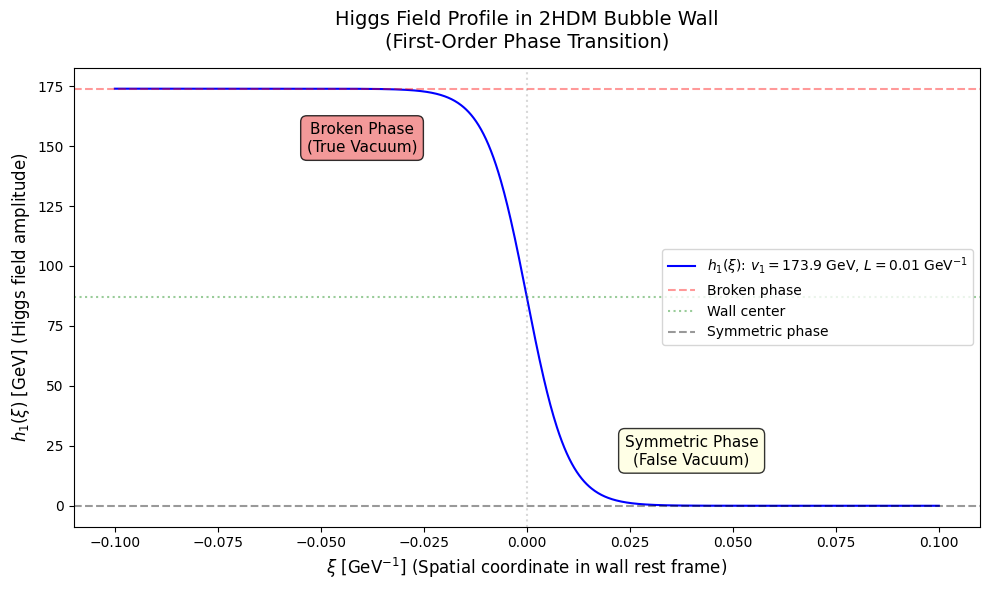

In [14]:
# HIGGS FIELD PROFILE PLOT

# Create spatial coordinate array and calculate field profile
xi_range = np.linspace(-10*L, 10*L, 1000)
h1_values = hi(v1, xi_range, L)

plot_higgs = True
if plot_higgs:
    # Create Higgs field plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(xi_range, h1_values, "b-", label=f"$h_1(\\xi)$: $v_1 = {v1:.4g}$ GeV, $L = {L:.3g}$ GeV$^{{-1}}$")

    # Add reference lines
    reference_lines = [
        (v1, "red", "--", "Broken phase"),
        (v1/2, "green", ":", "Wall center"),
        (0, "black", "--", "Symmetric phase")
    ]
    for y_val, color, style, label in reference_lines:
        ax.axhline(y=y_val, color=color, linestyle=style, alpha=0.4, label=label)

    ax.axvline(x=0, color="gray", linestyle=":", alpha=0.3)

    # Add phase annotations
    annotations = [
        ("Broken Phase\n(True Vacuum)", (-4*L, 0.85*v1), "lightcoral"),
        ("Symmetric Phase\n(False Vacuum)", (4*L, 0.1*v1), "lightyellow")
    ]
    for text, (x, y), color in annotations:
        ax.annotate(text, xy=(x, y), fontsize=11, ha="center",
                    bbox=dict(boxstyle="round,pad=0.4", facecolor=color, alpha=0.8))

    # Format Higgs plot
    ax.set_xlabel("$\\xi$ [GeV$^{-1}$] (Spatial coordinate in wall rest frame)", fontsize=12)
    ax.set_ylabel("$h_1(\\xi)$ [GeV] (Higgs field amplitude)", fontsize=12)
    ax.set_title("Higgs Field Profile in 2HDM Bubble Wall\n(First-Order Phase Transition)", 
                fontsize=14, pad=15)
    ax.legend(fontsize=10, loc="center right")
    plt.tight_layout()
    plt.show()

In [15]:
def create_params(tau, vW, L, d, delta_theta):
    """
    Create a standardized parameter dictionary for gravitational wave calculations.
    
    This function packages the key physical parameters into a dictionary format
    that can be easily passed to other functions and used for caching operations.
    
    Args:
    - tau (float): Cutoff time, defining the duration of the collision dynamics.
    - vW (float): Bubble wall velocity (normalized, e.g., close to speed of light = 1).
    - L (float): Bubble wall thickness [GeV^-1].
    - d (float): Bubble separation distance along the z-axis.
    - delta_theta (float): CP-violating phase parameter [dimensionless].
    
    Returns:
    - dict: Parameter dictionary with keys matching input argument names.
    """
    return {"tau": tau, "vW": vW, "L": L, "d": d, "delta_theta": delta_theta}

def params_to_cache_str(params, n_omega):
    """
    Convert parameter dictionary to a unique cache filename string.
    
    Args:
    - params (dict): Parameter dictionary from create_params().
    - n_omega (int): Number of frequency points in the calculation.

    Returns:
    - str: Cache filename string (without .pkl extension).
    
    Example:
    - "tau120_vW0.90_L0.01_d100_delta_theta1.00_n50"
    """
    return (f"tau{int(round(params['tau']))}_vW{params['vW']:.2f}_L{params['L']:.2f}_"
            f"d{int(round(params['d']))}_delta_theta{params['delta_theta']:.2f}_n{n_omega}")

def validate_cached_params(cached_data, params, rtol=1e-10):
    """
    Validate that cached parameters match current calculation parameters.
    
    Performs a comprehensive check to ensure cached data corresponds to the
    current parameter set. This prevents incorrect cache hits when parameters
    have changed between calculations.
    
    Args:
    - cached_data (dict): Loaded cache data containing parameters and results.
    - params (dict): Current parameter dictionary to compare against.
    - rtol (float): Relative tolerance for floating-point parameter comparison.

    Returns:
    - bool: True if all parameters match within tolerance, False otherwise.
    """
    # Check for missing parameter keys in cached data
    missing_keys = [key for key in params.keys() if key not in cached_data]
    if missing_keys:
        print(f"Missing keys in cache: {missing_keys}")
        return False
    
    # Check parameter values within tolerance
    for param in params.keys():
        cached_val = cached_data.get(param, 0)
        current_val = params[param]
        if abs(cached_val - current_val) >= rtol:
            print(f"Parameter mismatch - {param}: cached={cached_val}, current={current_val}")
            return False
    
    return True

def fit_power_law(x_data, y_data):
    """
    Fit a power law relationship y = A * x^n to log-log data using linear regression.
    
    Performs a least-squares fit in log-log space to extract the power law exponent
    and amplitude. This is commonly used to characterize the frequency scaling of
    gravitational wave spectra in different regimes (e.g., ω^3 at low frequencies).
    
    Args:
    - x_data (array): Independent variable data (e.g., frequency values).
    - y_data (array): Dependent variable data (e.g., spectral amplitude).
    
    Returns:
    - tuple: (power, amplitude) where:
        - power (float): Power law exponent n, or None if fit fails.
        - amplitude (float): Power law amplitude A, or None if fit fails.
    """
    if len(x_data) < 2:
        return None, None
    
    try:
        # Fit line to log10(y) vs log10(x): log10(y) = n*log10(x) + log10(A)
        log_fit = np.polyfit(np.log10(x_data), np.log10(y_data), 1)
        power = log_fit[0]      # Slope gives power law exponent
        amplitude = 10**log_fit[1]  # Intercept gives log10(amplitude)
        return power, amplitude
    except (ValueError, np.linalg.LinAlgError):
        return None, None

def load_or_compute_spectrum(delta_theta, n_omega, omega_values, tau, vW, L, gamma, d, v, beta):
    """
    Load gravitational wave spectrum from cache or compute if not available.
    
    Implements an intelligent caching system for expensive spectrum calculations.
    Attempts to load pre-computed results matching the current parameters,
    and falls back to full computation if no valid cache is found. Results
    are automatically saved for future use.
    
    Args:
    - delta_theta (float): CP-violating phase parameter [dimensionless].
    - n_omega (int): Number of frequency points for spectrum calculation.
    - omega_values (array): Frequency grid for spectrum evaluation [GeV].
    - tau (float): Cutoff time, defining the duration of the collision dynamics.
    - vW (float): Bubble wall velocity (normalized, e.g., close to speed of light = 1).
    - L (float): Bubble wall thickness [GeV^-1].
    - gamma (float): Lorentz factor γ = 1/√(1-vW²).
    - d (float): Bubble separation distance along the z-axis.
    - v (float): Standard Model Higgs VEV at T=0 [GeV].
    - beta (float): Mixing angle between two Higgs doublets [radians].

    Returns:
    - spectrum (array): Computed gravitational wave spectrum dE/dω * ω^3 [GeV^4].
    """
    # Create parameter signature for this calculation
    params = create_params(tau, vW, L, d, delta_theta)
    cache_filename = f"gwscaled_{params_to_cache_str(params, n_omega)}.pkl"
    
    # Attempt to load from existing cache
    if os.path.exists(cache_filename):
        try:
            with open(cache_filename, "rb") as f:
                cached_data = pickle.load(f)
            
            # Validate both parameters and frequency grid
            omega_match = np.allclose(cached_data.get("omega_values", []), omega_values, rtol=1e-10)
            params_match = validate_cached_params(cached_data, params)
            
            if omega_match and params_match:
                print(f"Loaded cached spectrum for delta_theta {delta_theta}")
                return cached_data["spectrum"]
        except Exception as e:
            print(f"Cache loading failed: {e}")
    
    # Compute spectrum from scratch
    print(f"Computing spectrum for delta_theta {delta_theta}")
    spectrum_unscaled = de_per_domega_apx_unscaled(
        tau, omega_values, vW, L, gamma, d, v, beta, delta_theta, show_progress=True)

    # Apply ω^3 scaling
    spectrum = spectrum_unscaled * omega_values**3
    
    # Save results to cache for future use
    cache_data = {**params, "omega_values": omega_values, "spectrum": spectrum}
    with open(cache_filename, "wb") as f:
        pickle.dump(cache_data, f)
    
    return spectrum

In [16]:
# GRAVITATIONAL WAVE SPECTRUM CALCULATION

# Bubble collision parameters
d = 200  # Bubble separation distance along the z-axis
alpha = 1.2  # Scaling factor for time cutoff
tau = alpha * d  # Time cutoff for integration
vW = 0.9  # Bubble wall velocity (normalized, close to speed of light = 1)
gamma = 1 / np.sqrt(1 - vW**2)  # Lorentz factor

# Frequency range setup
n_omega = 500
omega_min, omega_max = 0.1 / tau, 50.0 / tau
omega_values = np.logspace(np.log10(omega_min), np.log10(omega_max), n_omega)

# Calculate factor
factor = G * (gamma * L * vW**2)**2 / (2 * np.pi)

# Compute spectra for all CP-violating phases
delta_thetas = [0, 1]
all_spectra = [load_or_compute_spectrum(delta_theta, n_omega, omega_values, tau, vW, L, gamma, d, v, beta) for delta_theta in delta_thetas]

# Filter and normalize data
valid_mask = np.isfinite(all_spectra[0]) & (all_spectra[0] > 0)
if not np.any(valid_mask):
    print("Warning: No valid data points found in spectrum.")

omega_tau = omega_values[valid_mask] * tau
filtered_spectra = [spectrum[valid_mask] for spectrum in all_spectra]
normalized_spectra = tau**-3 * factor * np.array(filtered_spectra)

# Power law analysis
peak_idx = np.argmax(filtered_spectra[0])
n_points = len(omega_tau)
fit_fraction = 0.05

# Fit ranges
low_end = max(3, int(fit_fraction * n_points))
high_start = min(n_points - 3, int((1 - fit_fraction) * n_points))

# Power law fits
low_power, _ = fit_power_law(omega_tau[:low_end], filtered_spectra[0][:low_end])
high_power, _ = fit_power_law(omega_tau[high_start:], filtered_spectra[0][high_start:])
low_power, high_power = np.real(low_power), np.real(high_power)

Loaded cached spectrum for delta_theta 0
Loaded cached spectrum for delta_theta 1


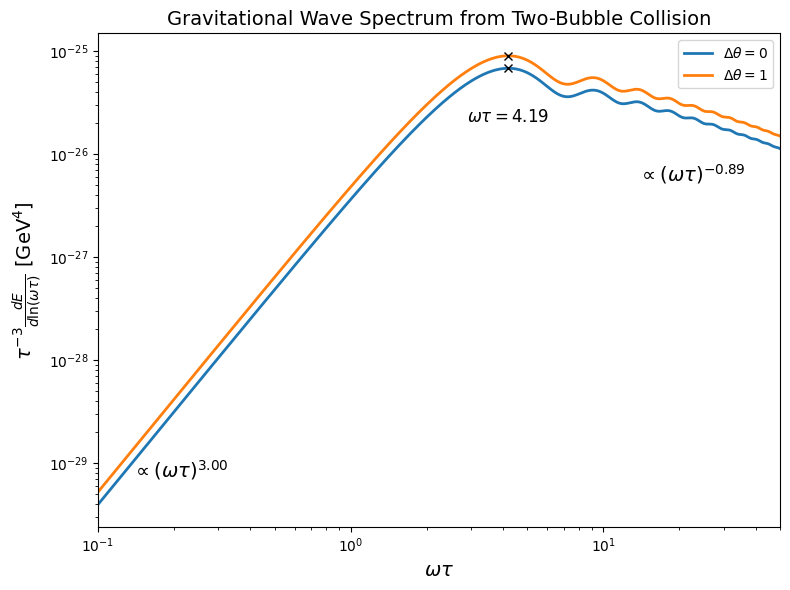

In [17]:
# SPECTRUM PLOTTING

fig, ax = plt.subplots(figsize=(8, 6))

# Plot spectra for different CP phases
for i, delta_theta in enumerate(delta_theta_values):
    spectrum = normalized_spectra[i]
    label = f"$\\Delta\\theta={delta_theta}$"
    ax.loglog(omega_tau, spectrum, label=label, linewidth=2)

# Mark peak
ax.loglog(omega_tau[peak_idx], normalized_spectra[0][peak_idx], marker="x", color="black")
ax.loglog(omega_tau[peak_idx], normalized_spectra[1][peak_idx], marker="x", color="black")

# Add peak annotation
peak_value = normalized_spectra[0][peak_idx]
ax.annotate(f"$\\omega\\tau={omega_tau[peak_idx]:.2f}$", 
            xy=(omega_tau[peak_idx], peak_value),
            xytext=(omega_tau[peak_idx], peak_value * 0.3),
            fontsize=12, ha="center")

# Add power law annotations
if low_power is not None:
    ax.text(0.05, 0.1, rf"$\propto (\omega\tau)^{{{low_power:.2f}}}$", 
            transform=ax.transAxes, fontsize=14, color="black", ha="left")
if high_power is not None:
    ax.text(0.95, 0.7, rf"$\propto (\omega\tau)^{{{high_power:.2f}}}$", 
            transform=ax.transAxes, fontsize=14, color="black", ha="right")

# Format spectrum plot
ax.set_xlabel(r"$\omega\tau$", fontsize=14)
ax.set_ylabel(r"$\tau^{-3}\frac{dE}{d\ln(\omega\tau)}$ [GeV$^4$]", fontsize=14)
ax.set_title("Gravitational Wave Spectrum from Two-Bubble Collision", fontsize=14)
ax.set_xlim([omega_tau[0], omega_tau[-1]])
ax.legend(loc="best", fontsize=10)

plt.tight_layout()
plt.savefig("Figure/gwplot_twobubble.png", dpi=300, bbox_inches="tight")
plt.show()